### Variance Futures at Eurex

* Variance futures replicate the payout of over-the-counter variance swaps 
* Traded at otc conventions of vega notional and at volatility strikes 
* Daily margin payments based on settlement prices add up to final settlement payoff of the OTC Variance swap
* EUREX variance futures began 22 September 2014

* NPV effects are accounted for by:
    * discount factor as mark-to-market for variance swaps
    * Accumulated return on modified variation margin for daily margin payments 
    
* Variance swaps based on end-of-day returns of respective index
* To mimic cash flow of a variance swap with the same terms 
    * intraday trades booked with desired quantity and prelim futures prices
    * end-of-day: at end of day, intraday trades are cancelled and rebooked with same quantity at futures settlement price, accounting for shifts in realized variance since intraday trade was booked

* Variance futures are quoted in Vega Notional and volatility strikes
* bookings and clearings are made only in futures and futures prices


#### Variance Futures Concepts

* Realized Variance 
    * $\sigma^2 = 10000 *\frac {252}{N} \sum_{n=1}^N R_n^2$
    * $S_n, n = 0,1,...N$ log returns $R_n = log \frac{S_n}{S_n-1}$
* Net Present Value
    * Daily margin cash flows of trading futures leads, time-wise, to different cash-flow profile than single payoff of variance future at maturity
    * Discount factor: $DF_t = e^-\frac{r(T-t)}{365}$
    * $r$ is interest rates and Eurex uses Euribor
    * low interest rates will have a muted impact on the discount factor
    

In [2]:
import pandas as pd
import warnings; warnings.simplefilter('ignore')


import seaborn as sns; sns.set()
import matplotlib
matplotlib.rcParams['font.family'] = 'serif'
%matplotlib inline
## read data from CSV file
eb = pd.read_csv('data/hist_EURIBOR_2015.csv',  # filename
                   index_col=0,  # index column
                   parse_dates=True,  # parsing date information
                   dayfirst=True)  # European date convention
eb.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 135 entries, 2015-01-02 to 2015-07-14
Data columns (total 8 columns):
1w     135 non-null float64
2w     135 non-null float64
1m     135 non-null float64
2m     135 non-null float64
3m     135 non-null float64
6m     135 non-null float64
9m     135 non-null float64
12m    135 non-null float64
dtypes: float64(8)
memory usage: 9.5 KB


### Discount Factor

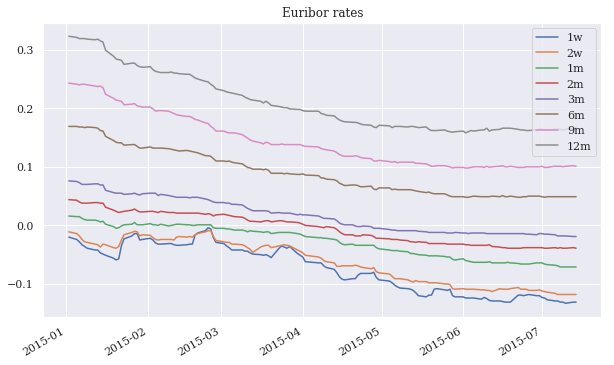

In [4]:
eb.plot(figsize=(10, 6), title='Euribor rates');

In [5]:
eb.tail()

,1w,2w,1m,2m,3m,6m,9m,12m
2015-07-08,-0.131,-0.118,-0.071,-0.038,-0.018,0.049,0.101,0.164
2015-07-09,-0.131,-0.118,-0.071,-0.039,-0.018,0.049,0.100,0.163
2015-07-10,-0.133,-0.118,-0.071,-0.039,-0.018,0.049,0.101,0.164
2015-07-13,-0.131,-0.118,-0.071,-0.038,-0.019,0.049,0.102,0.166
2015-07-14,-0.131,-0.118,-0.071,-0.039,-0.019,0.049,0.101,0.168


In [8]:
import math

# 12 month period discount factor is small
(1 - math.exp(-0.00168 * 365. / 365)) * 100

0.16785895899401604

### Accumulated Return on modified variation margin

* Variance futures trading leads to daily margin payments that have impact on present value of variance future 
* $ARMV_{M_t} = ARMV_{M_{t-1}} * e^{\frac{r \Delta t}{365}} + (F^S_{t-1} - C)(e^{\frac{r \Delta t}{365}} - 1)$
* $F^S_{t-1}$: variance future settlement price at t
* $C$: Constant set at 3000
* $r$ is EONIA Euro Overnight Index Average
* EONIA: weighted average of all overnight unsecured lending transactions in the EU interbank market

In [10]:
eo = pd.read_csv('data/hist_EONIA_2015.csv',  # filename
                   index_col=0,  # index column
                   parse_dates=True,  # parsing date information
                   dayfirst=True)  # European date convention
# eo.index = pd.DatetimeIndex(eo.index) 
eo.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2015-04-21 to 2015-07-14
Data columns (total 1 columns):
EONIA    60 non-null float64
dtypes: float64(1)
memory usage: 960.0 bytes


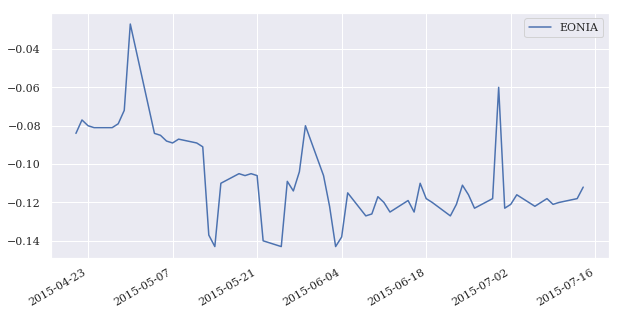

In [11]:
eo.plot(figsize=(10, 5));

In [12]:
r_eo = -0.001

In [13]:
ARMVM2 = 0 * math.exp(r_eo / 365) + (3000 - 3000) * (math.exp(r_eo / 365) - 1)
ARMVM2

0.0

In [17]:
ARMVM3 = 0 * math.exp(r_eo / 365) + (3100 - 3000) * (math.exp(r_eo / 365) - 1)
ARMVM3

-0.0002739722274380796

In [18]:
ARMVM4 = 0 * math.exp(r_eo / 365) + (3050 - 3000) * (math.exp(r_eo / 365) - 1)
ARMVM4

-0.0001369861137190398

#### Traded Variance Strike

* $\sigma^2_t$ at date $t$ is the time weighted average of the realized variance $\sigma^2_{0,t}$ weighted by the number of elapsed days $t$ and the traded implied variance $\sigma^2_{i}(t,T)$
* $\sigma^2_t = \frac {t * \sigma^2_{0,t} + (T-t) \sigma^2_{i}(t,T)}{T}$

#### Traded Futures Price

* $F_t$ = $DF_t$ * $(\sigma^2_t - \sigma^2_{i}(t,T))$ - $ARMV_{M_t} + 3000 $


#### Number of Futures

* Variance futures are traded in vega notional and volatility strikes
* Settlement takes place in futures (variance notional) and variance strikes
* $futures = \frac{VegaNotional}{2*\sigma^2_{i}(t,T)} * \frac{T}{T-t}$

#### Par Variance Strike
* $\sigma^2_p = \frac {t * \sigma^2_{0,t} + (T-t) \sigma^2_{i}}{T}$
* When log return for EUROSTOXX 50 is known, par variance strike $\sigma^2_p$ calculated using settled implied vol


#### Settled Futures Price

* $F^S_t$ = $DF_t$ * $(\sigma^2_p - \sigma^2_{K})$ - $ARMV_{M_t} + 3000 $
* Marked to market value of the corresponding variance swap minus ARMVM plus scaling factor of 3000




In [20]:
import pandas as pd
h5 = pd.HDFStore('data/SX5E_V6I1.h5', 'r')
data = h5['SX5E_V6I1']
h5.close()
data.head()

,SX5E,V6I1
b'Date',,
2015-06-01,3575.04,25.8710
2015-06-02,3561.89,25.9232
2015-06-03,3583.82,25.7958
2015-06-04,3556.38,26.2418
2015-06-05,3510.01,27.4496


In [21]:
data = data.join(eb['2w'], how='left')
data = data.join(eo, how='left')
data

,SX5E,V6I1,2w,EONIA
b'Date',,,,
2015-06-01,3575.04,25.8710,-0.108,-0.106
2015-06-02,3561.89,25.9232,-0.109,-0.122
2015-06-03,3583.82,25.7958,-0.109,-0.143
2015-06-04,3556.38,26.2418,-0.109,-0.138
2015-06-05,3510.01,27.4496,-0.109,-0.115
2015-06-08,3468.31,27.2996,-0.110,-0.127
2015-06-09,3456.79,26.8020,-0.110,-0.126
2015-06-10,3526.48,25.8610,-0.111,-0.117
2015-06-11,3551.91,26.3897,-0.111,-0.120


In [22]:
import numpy as np
data['R_t'] = np.log(data['SX5E'] / data['SX5E'].shift(1))
data['sigma**2'] = 10000 * 252 * (np.cumsum(data['R_t'] ** 2)
                                  / np.arange(len(data)))
data

,SX5E,V6I1,2w,EONIA,R_t,sigma**2
b'Date',,,,,,
2015-06-01,3575.04,25.8710,-0.108,-0.106,NaN,NaN
2015-06-02,3561.89,25.9232,-0.109,-0.122,-0.003685,34.220799
2015-06-03,3583.82,25.7958,-0.109,-0.143,0.006138,64.580457
2015-06-04,3556.38,26.2418,-0.109,-0.138,-0.007686,92.677552
2015-06-05,3510.01,27.4496,-0.109,-0.115,-0.013124,178.023718
2015-06-08,3468.31,27.2996,-0.110,-0.127,-0.011951,214.408816
2015-06-09,3456.79,26.8020,-0.110,-0.126,-0.003327,183.323049
2015-06-10,3526.48,25.8610,-0.111,-0.117,0.019960,300.555651
2015-06-11,3551.91,26.3897,-0.111,-0.120,0.007185,279.249096


In [23]:
T = 15.
data['t'] = np.arange(1, 16)
data['t']

b'Date'
2015-06-01     1
2015-06-02     2
2015-06-03     3
2015-06-04     4
2015-06-05     5
2015-06-08     6
2015-06-09     7
2015-06-10     8
2015-06-11     9
2015-06-12    10
2015-06-15    11
2015-06-16    12
2015-06-17    13
2015-06-18    14
2015-06-19    15
Name: t, dtype: int64

* Compute the Discount Factor

In [24]:
r_eb = -0.001
data['DF_t'] = np.exp(-r_eb * (T - data['t']) / 365.) 
data

,SX5E,V6I1,2w,EONIA,R_t,sigma**2,t,DF_t
b'Date',,,,,,,,
2015-06-01,3575.04,25.8710,-0.108,-0.106,NaN,NaN,1,1.000038
2015-06-02,3561.89,25.9232,-0.109,-0.122,-0.003685,34.220799,2,1.000036
2015-06-03,3583.82,25.7958,-0.109,-0.143,0.006138,64.580457,3,1.000033
2015-06-04,3556.38,26.2418,-0.109,-0.138,-0.007686,92.677552,4,1.000030
2015-06-05,3510.01,27.4496,-0.109,-0.115,-0.013124,178.023718,5,1.000027
2015-06-08,3468.31,27.2996,-0.110,-0.127,-0.011951,214.408816,6,1.000025
2015-06-09,3456.79,26.8020,-0.110,-0.126,-0.003327,183.323049,7,1.000022
2015-06-10,3526.48,25.8610,-0.111,-0.117,0.019960,300.555651,8,1.000019
2015-06-11,3551.91,26.3897,-0.111,-0.120,0.007185,279.249096,9,1.000016


In [26]:
# Compute Notional

#Using our strike volatility from day 0
sigma_K = data['V6I1'][0]
sigma_K
Notional = 100000 / (2 * sigma_K)
Notional

1932.665919369178

In [27]:
#On day 0 the settlement price is 3000
data['F_tS'] = 3000

data

,SX5E,V6I1,2w,EONIA,R_t,sigma**2,t,DF_t,F_tS
b'Date',,,,,,,,,
2015-06-01,3575.04,25.8710,-0.108,-0.106,NaN,NaN,1,1.000038,3000
2015-06-02,3561.89,25.9232,-0.109,-0.122,-0.003685,34.220799,2,1.000036,3000
2015-06-03,3583.82,25.7958,-0.109,-0.143,0.006138,64.580457,3,1.000033,3000
2015-06-04,3556.38,26.2418,-0.109,-0.138,-0.007686,92.677552,4,1.000030,3000
2015-06-05,3510.01,27.4496,-0.109,-0.115,-0.013124,178.023718,5,1.000027,3000
2015-06-08,3468.31,27.2996,-0.110,-0.127,-0.011951,214.408816,6,1.000025,3000
2015-06-09,3456.79,26.8020,-0.110,-0.126,-0.003327,183.323049,7,1.000022,3000
2015-06-10,3526.48,25.8610,-0.111,-0.117,0.019960,300.555651,8,1.000019,3000
2015-06-11,3551.91,26.3897,-0.111,-0.120,0.007185,279.249096,9,1.000016,3000


In [36]:
#Initial ARMV is 0 on day 0 (3000-3000)
data['ARMVM_t'] = 0.0

In [29]:
#Compute settlement for day 1
data['F_tS'][1] = data['DF_t'][1] * ((data['t'][1] * data['sigma**2'][1]
                    + (T - data['t'][1]) * data['V6I1'][1] ** 2) / T
                    - sigma_K ** 2) + 3000
data['F_tS'][1]   

2917

In [37]:
#Compute the ARMV with EONIA 
#Use ARMV to compute the settlement future price
for t in data.index[1:]:
    data['ARMVM_t'][t] = (data['ARMVM_t'].shift(1)[t]
                          * math.exp(data['EONIA'].shift(1)[t] / 252)
                       + (data['F_tS'].shift(1)[t] - 3000)
                         * (math.exp(data['EONIA'].shift(1)[t] / 252) - 1))
    data['F_tS'][t] = data['DF_t'][t] * ((data['t'][t] * data['sigma**2'][t]
                          + (T - data['t'][t]) * data['V6I1'][t] ** 2) / T
                          - sigma_K ** 2) - data['ARMVM_t'][t] + 3000

In [38]:
data.tail()

,SX5E,V6I1,2w,EONIA,R_t,sigma**2,t,DF_t,F_tS,ARMVM_t
b'Date',,,,,,,,,,
2015-06-15,3438.07,34.5593,-0.108,-0.119,-0.018644,359.901600,11,1.000011,2912,0.689681
2015-06-16,3454.09,36.2222,-0.109,-0.125,0.004649,332.134168,12,1.000008,2858,0.730901
2015-06-17,3428.76,34.7235,-0.109,-0.110,-0.007360,315.833038,13,1.000005,2764,0.800957
2015-06-18,3450.45,34.7235,-0.109,-0.118,0.006306,299.246550,14,1.000003,2689,0.903601
2015-06-19,3455.80,34.7235,-0.108,-0.120,0.001549,278.303868,15,1.000000,2607,1.048771


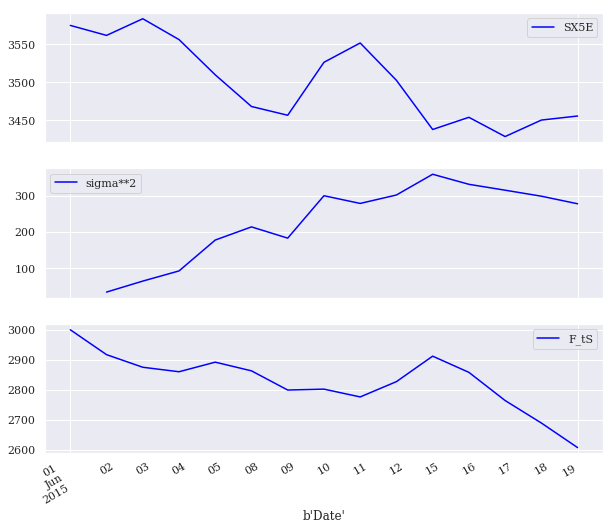

In [33]:
data[['SX5E', 'sigma**2', 'F_tS']].plot(subplots=True,
                                       color='blue',
                                       figsize=(10, 9));

In [34]:
h5 = pd.HDFStore('data/var_data.h5', 'r')
var_swap = h5['var_swap']
h5.close()

* Compare the variance swap and the variance futures
* The mark-to-market values and the values calculated here are pretty close

In [35]:
comp = pd.DataFrame({'F_tS': data['F_tS'] - 3000,
                     'V_t': var_swap['V_t']}, index=data.index)
comp

,F_tS,V_t
b'Date',,
2015-06-01,0,0.000000
2015-06-02,-83,-82.332277
2015-06-03,-125,-124.049833
2015-06-04,-140,-139.593571
2015-06-05,-108,-107.644092
2015-06-08,-137,-136.380856
2015-06-09,-201,-200.634978
2015-06-10,-198,-196.905901
2015-06-11,-224,-223.189008


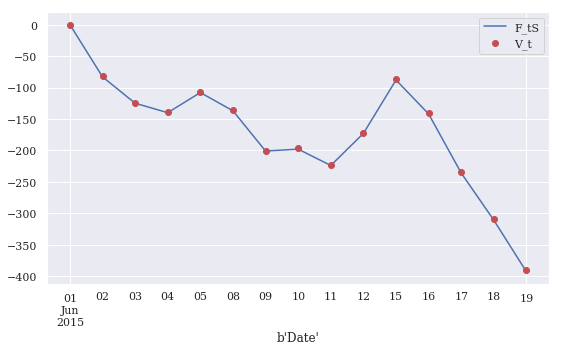

In [39]:
comp.plot(style=['b', 'ro'], figsize=(9, 5));

In [ ]:
# The 

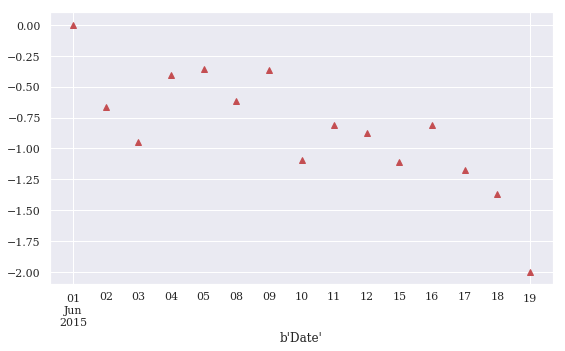

In [40]:
(comp['F_tS'] - comp['V_t']).plot(style='r^', figsize=(9, 5));